In [1]:
import pandas as pd
import numpy as np
import pylab as plt

In [2]:
sequence_length = 40
prediction_horizon = 20

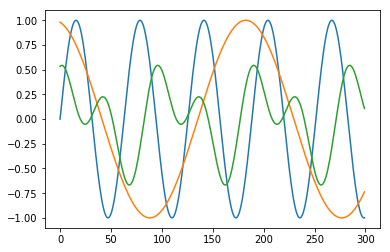

In [3]:
t = np.array([x/10 for x in range(300)])
a = np.sin(t)
b = np.cos(t/3 + 0.2)
r = np.random.rand(300)
y = (np.sin(t + prediction_horizon) * np.cos((t+ prediction_horizon)/3 + 0.2))*0.7

plt.plot(a)
plt.plot(b)
plt.plot(y)
# plt.plot(r)

# inputs = np.c_[t,a,b,r][:250]
# inputs = np.c_[t][:250]
inputs = np.c_[a,b][:250]
labels = y[:250].reshape(-1, 1)

# test_x = np.c_[t,a,b,r][250:]
# test_x = np.c_[t][250:]
test_x = np.c_[a,b][250:]
test_y = y[250:].reshape(-1, 1)



from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaler.fit(inputs)
y_scaler.fit(labels)

inputs = x_scaler.transform(inputs)
test_x = x_scaler.transform(test_x)

labels = y_scaler.transform(labels)
test_y = y_scaler.transform(test_y)

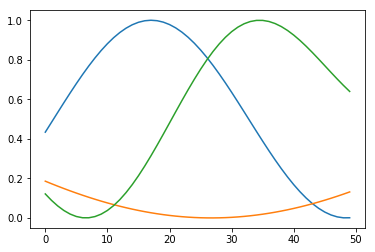

In [4]:
plt.plot(test_x)
plt.plot(test_y)

In [5]:
def extend_arr(arr, shift):
    result_arr = arr.copy()
    for i in range(shift):
        result_arr = np.concatenate( (result_arr, arr[i:]), axis=0 )
    
    return result_arr

In [6]:
labels = extend_arr(labels, sequence_length)
inputs = extend_arr(inputs, sequence_length)

# print(labels.shape, inputs.shape)

tail = labels.shape[0]%sequence_length
labels = labels[tail:]
inputs = inputs[tail:]

# print(labels.shape, inputs.shape)


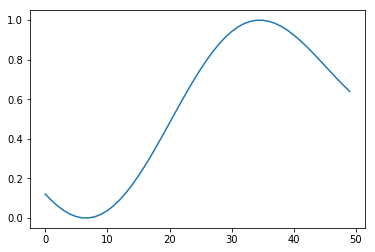

In [7]:
plt.plot(test_y)

In [8]:
inputs.shape

(9440, 2)

In [9]:
def create_batcher(vec, seq_len = 1):
    vec_len = len(vec)
    try:
        n_cols = vec.shape[1]
    except:
        n_cols = 1
#     return (vec[i:i+seq_len].reshape(-1, seq_len, n_cols) for i in range(vec_len - seq_len))
    return (vec[i*seq_len: (i+1)*seq_len].reshape(-1, seq_len, n_cols) for i in range(vec_len//seq_len))


In [10]:
import tensorflow as tf

seed = 43

tf.reset_default_graph()
tf.set_random_seed(seed)

n_layers = 2
n_inputs =  inputs.shape[1]
n_outputs = 1
n_neurons = 150

learn_rate = 0.001

cell = tf.nn.rnn_cell.LSTMCell

X = tf.placeholder(dtype=tf.float32, shape=(None, sequence_length, n_inputs))
y = tf.placeholder(dtype=tf.float32, shape=(None, sequence_length, n_outputs))

layers = [cell(num_units=n_neurons, activation=tf.nn.tanh) for l in range(n_layers) ]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, sequence_length, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


# for i in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
#     print( i )   # i.name if you want just a name


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [11]:
model_name='sine_predictor'

EPOCH 0 | MSE 0.05995861068367958 | TEST MSE 0.034182023257017136
EPOCH 100 | MSE 0.0005720002227462828 | TEST MSE 0.00015619018813595176
EPOCH 200 | MSE 0.00010293426021235064 | TEST MSE 2.5394527256139554e-05
min mse = 3.2223688322119415e-06 at epoch 224


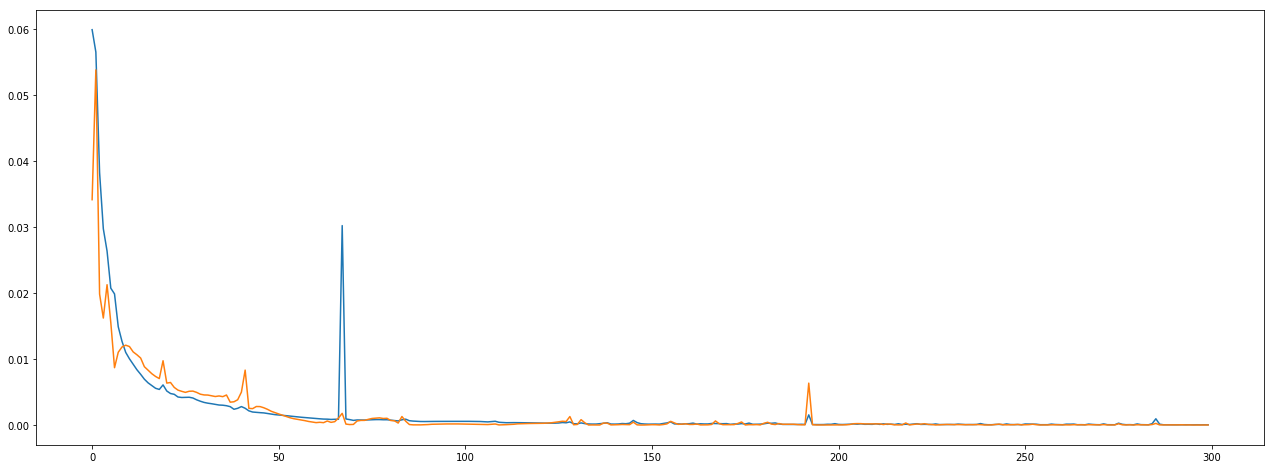

In [12]:
from time import time

x_batcher = create_batcher(inputs, seq_len=sequence_length)
y_batcher = create_batcher(labels, seq_len=sequence_length)

n_epochs = 300
lag = 100
min_mse = 1000
min_mse_epoch = 0
mse_train_stack = []
mse_test_stack = []


with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        x_batcher = create_batcher(inputs, seq_len=sequence_length)
        y_batcher = create_batcher(labels, seq_len=sequence_length)
        for X_batch, y_batch in zip(x_batcher, y_batcher):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        mse = sess.run(loss, feed_dict={X:inputs.reshape(-1, sequence_length, n_inputs), 
                                  y:labels.reshape(-1, sequence_length, n_outputs)})
        test_mse = sess.run(loss, feed_dict={X:test_x[10:].reshape(-1, sequence_length, n_inputs),
                                             y:test_y[10:].reshape(-1, sequence_length, n_outputs)})
        mse_train_stack.append(mse)
        mse_test_stack.append(test_mse)
        if not epoch % 100:
            print(f'EPOCH {epoch} | MSE {mse} | TEST MSE {test_mse}')
        if epoch > lag and np.abs(test_mse - mse) < min_mse:
            min_mse = np.abs(test_mse - mse)
            min_mse_epoch = epoch
            saver.save(sess, f'./models/{model_name}')
    print(f'min mse = {min_mse} at epoch {min_mse_epoch}')


plt.figure(figsize=(22, 8))
plt.plot(mse_train_stack)
plt.plot(mse_test_stack)

INFO:tensorflow:Restoring parameters from ./models/sine_predictor


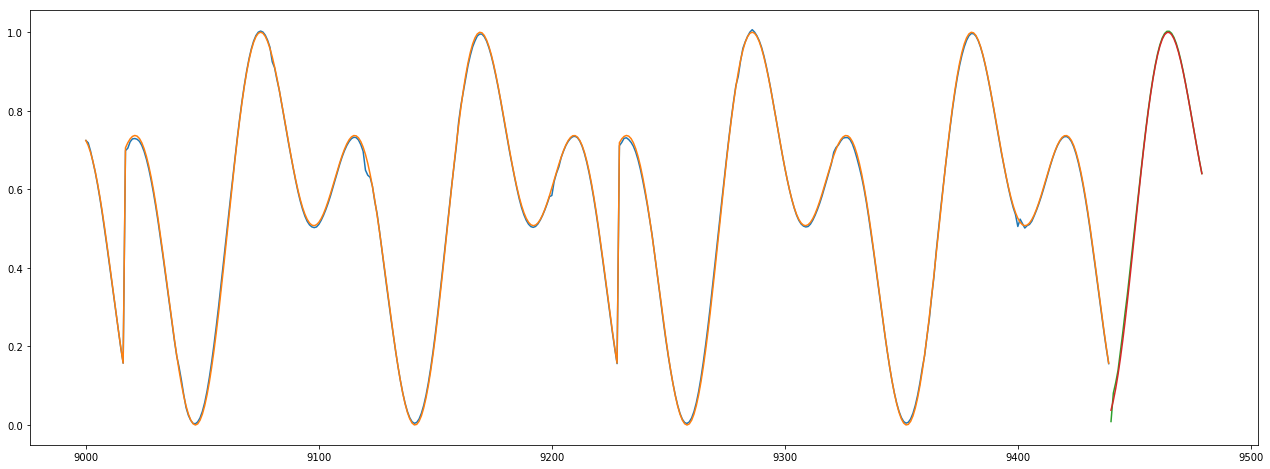

In [16]:
with tf.Session() as sess:
    saver.restore(sess, f'./models/{model_name}')
    y_pred_test = sess.run(outputs, feed_dict={X:test_x[10:].reshape(-1, sequence_length, n_inputs)})
    y_pred_train = sess.run(outputs, feed_dict={X:inputs.reshape(-1, sequence_length, n_inputs)})

train_len = labels.shape[0]
begin = 9000
    
plt.figure(figsize=(22, 8))
plt.plot(range(begin, train_len), y_pred_train.ravel()[begin:])
plt.plot(range(begin, train_len), labels[begin:])
plt.plot(range(train_len, train_len + 40), y_pred_test.ravel())
plt.plot(range(train_len, train_len + 40), test_y[10:])

INFO:tensorflow:Restoring parameters from ./models/sine_predictor


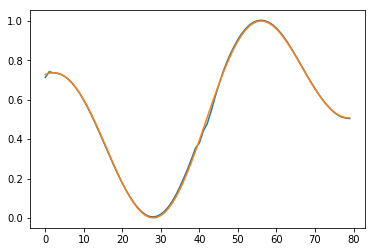

In [14]:
with tf.Session() as sess:
    saver.restore(sess, f'./models/{model_name}')
    y_pred_test = sess.run(outputs, feed_dict={X:test_x[10:90].reshape(-1, sequence_length, n_inputs)})
    y_pred_train = sess.run(outputs, feed_dict={X:inputs[10:90].reshape(-1, sequence_length, n_inputs)})

plt.plot(range(80), y_pred_train.ravel())
plt.plot(range(80), labels[10:90])
